# <p style="text-align: center;"> CS6476 | Computer Vision ps4 </p>
<p style="text-align: center;">Alexis Durocher - MSCS student at Georgia Tech</p>
<p style="text-align: center;">Spring 2018</p>


In [1]:
import cv2

from scipy import ndimage
from scipy import misc
import math as mt
import numpy as np
import math as mtugh
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from  scipy.optimize import minimize

<i> In this project, the aim is to compute features for model fitting. First, we will use the Harris detector to find 'keypoints' in picture, namely : edges. Edges have interesting properties (repetability, robustness, invariance, well localizable among others), which make them great candidates for features. Then we will the SIFT method to create descriptors on top of those keypoints. Finally, we will use RANSAC to find consensus between two bags of descriptors. </i>

### 1. Haris Corner

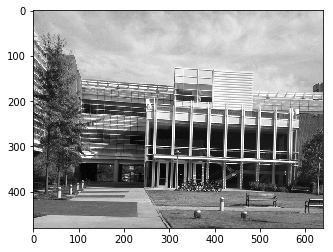

In [2]:
transA = cv2.imread('./transA.jpg')
transB = cv2.imread('./transB.jpg')
simA = cv2.imread('./simA.jpg')
simB = cv2.imread('./simB.jpg')
transA_gray = cv2.imread('./transA.jpg',0)
transB_gray = cv2.imread('./transB.jpg',0)
simA_gray = cv2.imread('./simA.jpg',0)
simB_gray = cv2.imread('./simB.jpg',0)

plt.imshow(transA_gray, cmap= 'gray')
plt.show()

#### 1.1  Gradient picture

In [3]:
def compute_gradient(kernel, picture):
    height, width = picture.shape
    kl = len(kernel)
    ks = int((kl - 1)/2)
    gradient = np.zeros(picture.shape)
    
    for row in range(ks, height - ks):
        for col in range(ks, width - ks):
            grad = 0
            for ki in range(kl):
                for kj in range(kl):
                    # compute convolution
                    grad += grad + (picture[row-ks+ki][col-ks+kj] * kernel[ki][kj]) 
            gradient[row, col] = grad        
        
    return gradient

def image_pair(image1, image2):
    return np.concatenate([image1, image2], axis =1)

In [4]:
kernel_x = np.array([[-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]])

kernel_y = np.array([[-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]])

In [5]:
transA_gradX = compute_gradient(kernel_x, transA_gray)
transA_gradY = compute_gradient(kernel_y, transA_gray)
transA_pair_grad = image_pair(transA_gradX, transA_gradY)

In [6]:
simA_gradX = compute_gradient(kernel_x, simA_gray)
simA_gradY = compute_gradient(kernel_y, simA_gray)
simA_pair_grad = image_pair(simA_gradX, simA_gradY)

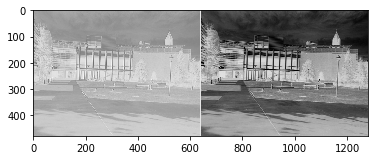

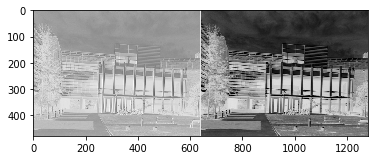

In [7]:
plt.imshow(simA_pair_grad, cmap= 'gray')
plt.savefig('./output/PS4-1-1-1.jpg')
plt.show()
plt.imshow(transA_pair_grad, cmap= 'gray')
plt.savefig('./output/PS4-1-1-2.jpg')
plt.show()

#### 1.2 Harris value

In [8]:
def compute_M(window, row, col, grad_x_picture, grad_y_picture):
    M = np.zeros((2,2))
    w_size = window.shape[0]
    ks = int((w_size-1)/2)
    for x in range(row - ks, row + ks):
        for y in range(col - ks, col + ks):
            grad_x2 = grad_x_picture[x, y] * grad_x_picture[x, y]
            grad_xy = grad_x_picture[x, y] * grad_y_picture[x, y]
            grad_y2 = grad_y_picture[x, y] * grad_y_picture[x, y]
            M_temp = window[abs((row-ks) - x) , abs((col-ks) - y)] * np.array([
                [grad_x2, grad_xy],
                [grad_xy, grad_y2]
            ])
            M += M_temp
    return M

def compute_R(M):
    R = cv2.determinant(M) - 0.04*cv2.trace(M)[0]
    return R

def compute_dst(grad_x_picture, grad_y_picture, w_size):
    height, width = grad_x_picture.shape
    # full of 1 now
    window = np.full((w_size, w_size), fill_value=int(1))
    ks = int((w_size-1)/2)
    dst = np.zeros((height, width))
    for row in range(ks,  height - ks):
        for col in range(ks, width - ks):
            M = compute_M(window, row, col, grad_x_picture, grad_y_picture)
            R = compute_R(M)
            dst[row, col] = R
    
    return dst

In [9]:
def compute_harris_image(picture = simA.copy(), w_size = 3):
    gray =cv2.cvtColor(picture, cv2.COLOR_BGR2GRAY)
    grad_x_picture = compute_gradient(kernel_x, gray)
    grad_y_picture = compute_gradient(kernel_y, gray)
    dst = compute_dst(grad_x_picture, grad_y_picture, w_size)
    normalized = dst.copy()
    normalized = cv2.normalize(src = dst, dst = normalized, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return normalized

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((3, 3), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


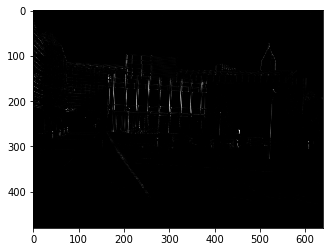

In [10]:
har_simA = compute_harris_image(simA.copy())
plt.imshow(har_simA, cmap = 'gray')
plt.savefig('./output/PS4-1-2-1.jpg')
plt.show()

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((3, 3), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


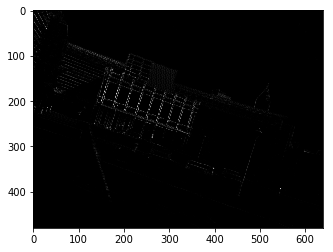

In [11]:
har_simB = compute_harris_image(simB.copy())
plt.imshow(har_simB, cmap = 'gray')
plt.savefig('./output/PS4-1-2-2.jpg')
plt.show()

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((3, 3), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


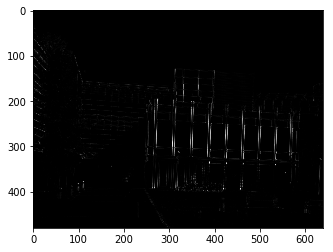

In [12]:
har_transA = compute_harris_image(transA.copy())
plt.imshow(har_transA, cmap = 'gray')
plt.savefig('./output/PS4-1-2-3.jpg')
plt.show()

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((3, 3), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


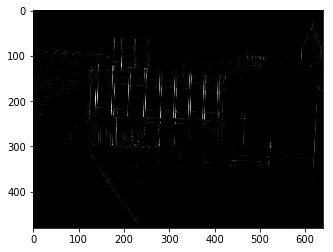

In [13]:
har_transB = compute_harris_image(transB.copy())
plt.imshow(har_transB, cmap = 'gray')
plt.savefig('./output/PS4-1-2-4.jpg')
plt.show()

#### 1.3 Harris detector

In [14]:
def compute_Harris(picture = simA.copy(), w_size = 3, alpha = 0.3):
    gray = cv2.cvtColor(picture, cv2.COLOR_BGR2GRAY)
    grad_x_picture = compute_gradient(kernel_x, gray)
    grad_y_picture = compute_gradient(kernel_y, gray)
    dst = compute_dst(grad_x_picture, grad_y_picture, w_size)
    #result is dilated
    dst_dil = cv2.dilate(dst,None)
    # Threshold for an optimal value, it may vary depending on the image.
    keypoints_idx = np.where(dst_dil>alpha*dst_dil.max())
    picture[keypoints_idx]=[0,0,255]
    keypoints = [cv2.KeyPoint(r,c,10) for r,c in zip(keypoints_idx[1], keypoints_idx[0])]
    return picture, keypoints

In [15]:
# defining image pair
image_sim_pair = image_pair(simA.copy(), simB.copy())
sim_gray_pair = image_pair(simA_gray.copy(), simB_gray.copy())
image_trans_pair = image_pair(transA.copy(), transB.copy())
trans_gray_pair = image_pair(transA.copy(), transB.copy())

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((3, 3), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


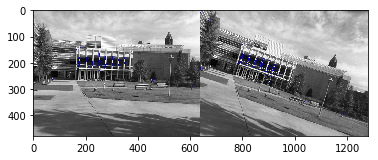

In [16]:
sim_harris, sim_keypoints = compute_Harris(image_sim_pair.copy(),3,0.5)
plt.imshow(sim_harris)
plt.savefig('./output/PS4-1-3-1.jpg')
plt.show()

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((3, 3), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


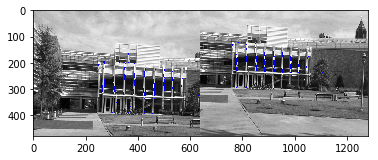

In [17]:
trans_harris, trans_keypoints = compute_Harris(image_trans_pair.copy(),3,0.5)
plt.imshow(trans_harris)
plt.savefig('./output/PS4-1-3-2.jpg')
plt.show()

<u> Interpretation </u>

Surprisingly, all the points detected don't necessarily correspond to corners. However we can see that keypoints are detected at corresponding locations in A and B picture so they are great features for picture matching. Our treshold is not fixed, it is proportional to the max value on distance (R) on a picture. Hence, since the building provides huge R magnitude on its windows, (black and white), it makes sense that other corner are ignored - too low for the treshold.

### 2. SIFT Features

Note that corners detected in Harris method (cf. 1.) are rotation invariant - a corner in a rotated picture remains a corner in the original one - but what about scale ? Harris corners are very sensitive to scale in a sense that, a corner at one scale can become flat at an other scale. In this second part, we will use SIFT detection to propose scale-invariant features.

#### 2.1 Compute angles picture

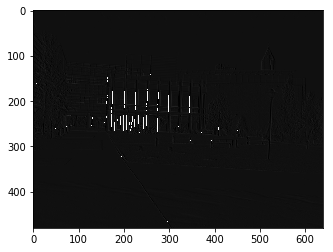

In [18]:
angle = np.arctan2(simA_gradX, simA_gradY)
plt.imshow(angle, cmap='gray')
plt.show()

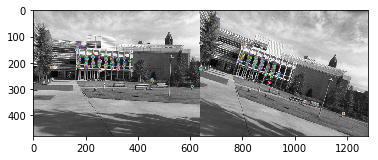

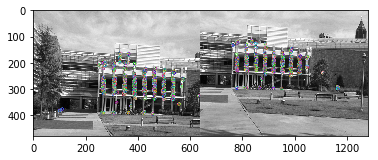

In [19]:
# convert in cv2 keypoints class
sim_pair_copy_kp = sim_gray_pair.copy()
sim_pair_copy_kp=cv2.drawKeypoints(sim_gray_pair, sim_keypoints, outImage = sim_pair_copy_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sim_pair_copy_kp)
plt.savefig('./output/PS4-2-1-1.jpg')
plt.show()

trans_pair_copy_kp = trans_gray_pair.copy()
trans_pair_copy_kp = cv2.drawKeypoints(trans_gray_pair, trans_keypoints, outImage = trans_pair_copy_kp, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(trans_pair_copy_kp)
plt.savefig('./output/PS4-2-1-2.jpg')
plt.show()

In [20]:
# using openCV
def detect_SIFT_NO_USE(picture):
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(picture, None)
    picture=cv2.drawKeypoints(picture, kp, outImage = picture, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    return picture, kp

In [23]:
pic, kp_simA = compute_Harris(simA.copy(),3,0.5)
pic, kp_simB = compute_Harris(simB.copy(),3,0.5)
pic, kp_transA = compute_Harris(transA.copy(),3,0.5)
pic, kp_transB = compute_Harris(transB.copy(),3,0.5)

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:301: FutureWarning: in the future, full((3, 3), 1) will return an array of dtype('int64')
  format(shape, fill_value, array(fill_value).dtype), FutureWarning)


#### 2.2 SIFT Desciptor and putative matches

We will now compute the descriptor of each keypoints. A descriptor is a way to "descript" a keypoint. It is computed by using the keypoint's neighborhood window (16x16). This window is then subdivised in 16 (4x4) subwindows where a 8 bin orientation histogram is computed (describring the "trend" of the gradient orientation in this subwindow). All of those 8 bin values will be appended in a 128 sized array (8 * 16). This 128 sized array is what we call a SIFT descriptor : it contains all the information about the gradient's orientation in the neighborhood of a keypoint. We use distance between descriptors as a metric to match keypoints accurately. 

<u> Compute descriptors </u>

In [34]:
### takes time ###
sift = cv2.xfeatures2d.SIFT_create()
kp_simA, des_simA = sift.compute(simA_gray, kp_simA)
kp_simB, des_simB = sift.compute(simB_gray, kp_simB)

kp_transA, des_transA = sift.compute(transA_gray, kp_transA)
kp_transB, des_transB = sift.compute(transB_gray, kp_transB)

<u> Match descriptors </u>

We will use a Brute Force Matcher using KNN method (k = 2). We use k = 2, so we can have the first and second best pair of matches, for each keypoint. We only want to keep matches that are not close to other matches. Indeed, noise can lead to false positive : pair of matches that don't correspond to the same keypoints.

In [57]:
def compute_good_matches(desA, desB):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desA, desB, k=2)
    #print(matches)
    # Apply ratio test - avoid false positives
    good = []
    for m,n in matches:
        if m.distance < 0.99*n.distance:
            good.append([m])
    return [m for [m] in good]   

def build_putative_pair_image(picture1, picture2, good_pts):
    ##### BFMatcher with default params
    putative_pair_image = np.concatenate((picture1, picture2), axis = 1)
    height, width, rgb = picture1.shape
    for (p_A, p_B) in good_pts:
        #p_A = tuple(int(i) for i in kpA[m.queryIdx].pt)
        #p_B = tuple(int(j) for j in kpB[m.trainIdx].pt)
        # draw point on the picture2 - consider picture1's width
        p_B = (p_B[0] + width, p_B[1])
        clr = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        cv2.line(putative_pair_image, p_A, p_B, clr, 3)
    
    return putative_pair_image

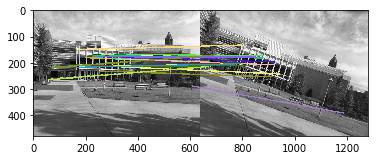

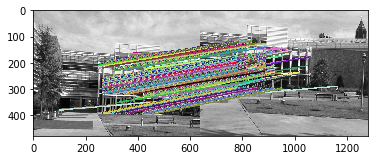

In [58]:
good_sim = compute_good_matches(des_simA, des_simB)
#print(good_sim)
good_pts_sim = [(tuple(int(i) for i in kp_simA[m.queryIdx].pt), tuple(int(j) for j in kp_simB[m.trainIdx].pt))
            for m in good_sim]
putative_pair_sim_image = build_putative_pair_image(simA, simB, good_pts_sim)
plt.imshow(putative_pair_sim_image)
plt.savefig('./output/PS4-2-2-1.jpg')
plt.show()

good_trans = compute_good_matches(des_transA, des_transB)
good_pts_trans = [(tuple(int(i) for i in kp_transA[m.queryIdx].pt), tuple(int(j) for j in kp_transB[m.trainIdx].pt))
            for m in good_trans]
putative_pair_trans_image = build_putative_pair_image(transA, transB, good_pts_trans)
plt.imshow(putative_pair_trans_image)
plt.savefig('./output/PS4-2-2-2.jpg')
plt.show()

### 3. RANSAC

#### 3.1 Translation Ransac

Now that we have putatives pairs of descriptors. We will apply a RANSAC algorithm to "vote" for the best translation vector between one picture and an other. RANSAC compare the translated point (kB_hat) to the real point (kB) from a putative pair and vote iteratively. The translation with the highest vote, correspond to the best translation model.

In [94]:

def compute_translation_vec(kpA, kpB, m):
    vec = np.array([
        kpB[m.trainIdx].pt[0] - kpA[m.queryIdx].pt[0],
        kpB[m.trainIdx].pt[1] - kpA[m.queryIdx].pt[1]])
    #print(vec)
    return vec

# return true if the distance between the projected point is near the real point.
def consensus(kA, kB, vec, epsilon = 10):
    kB_hat = kA+vec
    norm = np.linalg.norm(kB_hat - kB)
    return norm <= epsilon
    

def compute_ransac(desA, desB, kpA, kpB):
    good = compute_good_matches(desA, desB)
    vote = []
    m_size = len(good)
    for m1 in good:
        vote_m1 = 0
        vec1 = compute_translation_vec(kpA, kpB, m1)
        # voting : compare with all other matches
        for m2 in good :
            k2_A = np.array(kpA[m2.queryIdx].pt)
            k2_B = np.array(kpB[m2.trainIdx].pt)
            if consensus(k2_A, k2_B, vec1, 20):
                vote_m1 +=1
        vote.append([vote_m1])
        
    vote = np.array([vote for [vote] in vote])
    #print(vote)
    best_m = good[np.argmax(vote)]
    best_v = compute_translation_vec(kpA, kpB, best_m)
    best_prct = (np.max(vote)/m_size) * 15
    return best_m, best_v, best_prct


translation vector : [-143.  -88.] 
pourcentage : 6.13253012048%


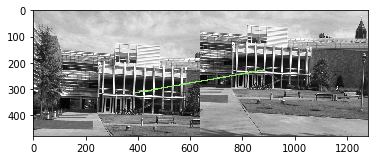

In [95]:
best_m_trans, best_v_trans, best_prct_trans = compute_ransac(des_transA, des_transB, kp_transA, kp_transB)

print('translation vector : ' + str(best_v_trans), '\npourcentage : '  + str(best_prct_trans) + '%')
best_pts_trans = [
    (tuple(int(i) for i in kp_transA[best_m_trans.queryIdx].pt),
     tuple(int(j) for j in kp_transB[best_m_trans.trainIdx].pt))]
best_putative_pair_trans_image = build_putative_pair_image(transA, transB, best_pts_trans)
plt.imshow(best_putative_pair_trans_image)
plt.savefig('./output/PS4-3-2-1.jpg')
plt.show()

#### 3.2 Similarity model

Now we will use a similarity model (matrix 2,3) in our RANSAC to find the best model between our matches. This model is composed of 4 unknowns. 

In [102]:
def build_similarity_model(kpA1, kpB1, kpA2, kpB2):
    [u1, v1], [u1p, v1p], [u2, v2], [u2p, v2p] = kpA1, kpB1, kpA2, kpB2
    beta = (v1p - u2) - (v1 - v2)*(u1p - u2p) / (u1 - v2p)
    alpha = ((u1 - u2) + (v1 - v2)**2 / (u1 - u2))
    b = beta / alpha
    a = ((u1p - u2p) + (v1 - v2)*b) / (u1 - u2)
    c = u1p - u1*a + b*v1
    d = v1p - u1*b - v1*a
    return(np.array([[a, -b, c],
                     [b, a, d]]))

def compute_similarity(kA, sim):
    return np.array(np.dot(sim, np.concatenate((kA, [1]))), dtype='int32')

def compute_similarity_ransac(desA, desB, kpA, kpB):
    epsilon = 10
    good_m = compute_good_matches(desA, desB)
    vote = []
    m_size = len(good_m)
    high_treshold = int(m_size/3)
    #print(m_size)
    max_vote = 0
    epoch =0
    best_model = np.zeros((2,3))
    while((epoch < 2*m_size)):
        epoch +=1
        vote_k = 0 
        # pick two random matches
        m1 = good_m[np.random.randint(0, m_size)]
        m2 = good_m[np.random.randint(0, m_size)]
        sim = build_similarity_model(np.array(kpA[m1.queryIdx].pt), np.array(kpB[m1.trainIdx].pt), np.array(kpA[m2.queryIdx].pt), np.array(kpB[m2.trainIdx].pt))
        trial_m = []
        
        for m in good_m :
            k2_A = np.array(kpA[m.queryIdx].pt)
            k2_B = np.array(kpB[m.trainIdx].pt)
            k2_B_hat = compute_similarity(k2_A, sim)
            #print(k2_B_hat)
            
            # vote if good model
            if (np.linalg.norm(k2_B_hat - k2_B) < epsilon):
                vote_k +=1
                trial_m.append(m)
                
            if vote_k > max_vote:
                max_vote = vote_k
                best_sim = sim
                best_prct = (max_vote/m_size)*100
                best_ms = trial_m
                
    return max_vote, best_sim, best_prct, best_ms

In [103]:
max_vote, best_sim, best_prct, best_ms = compute_similarity_ransac(des_simA, des_simB, kp_simA, kp_simB)

/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in double_scalars
/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars
/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in double_scalars


In [99]:
print('best similarity ' + str(best_sim), '\nbest pourcentage ' + str(best_prct))

best similarity [[  0.96741123  -0.29750853  46.17066272]
 [  0.29750853   0.96741123 -60.01875309]] 
best pourcentage 67.74193548387096


We have the list of best keypoints and the best similarity model. 
We can now plot the corresponding lines on the picture.

In [100]:
best_pts_ransac = []
for m in best_ms:
    k2_A = tuple(np.array(kp_simA[m.queryIdx].pt, dtype='int32'))
    k2_B_hat = tuple(compute_similarity(k2_A, best_sim))
    best_pts_ransac.append([(k2_A, k2_B_hat)])

best_pts_ransac = [pt for [pt] in best_pts_ransac]

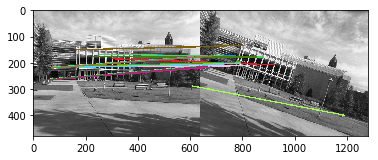

In [101]:
best_putative_pair_sim_image = build_putative_pair_image(simA, simB, best_pts_ransac)
plt.imshow(best_putative_pair_sim_image)
plt.savefig('./output/PS4-3-2-2.jpg')
plt.show()